# 02. Anomaly and Outlier Detection

## Objectives
- Detect and handle domain-specific anomalies
- Identify statistical outliers using IQR method
- Use Isolation Forest for multivariate outlier detection
- Create clean dataset for feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
data_dir = Path('../../data/raw/home-credit-default-risk')
df_train = pd.read_csv(data_dir / 'application_train.csv')

print(f"Original shape: {df_train.shape}")
print(f"Default rate: {df_train['TARGET'].mean():.4%}")

Original shape: (307511, 122)
Default rate: 8.0729%


## 2. Domain-Specific Anomalies

### 2.1 DAYS_EMPLOYED Anomaly

In [3]:
# Known anomaly: 365243 in DAYS_EMPLOYED
print("DAYS_EMPLOYED Analysis:")
print(f"Max: {df_train['DAYS_EMPLOYED'].max()}")
print(f"Min: {df_train['DAYS_EMPLOYED'].min()}")
print(f"\nRecords with 365243: {(df_train['DAYS_EMPLOYED'] == 365243).sum()}")
print(f"Percentage: {(df_train['DAYS_EMPLOYED'] == 365243).mean():.2%}")

# Check if these are pensioners or unemployed
anomaly_mask = df_train['DAYS_EMPLOYED'] == 365243
print("\nIncome types for anomaly records:")
print(df_train[anomaly_mask]['NAME_INCOME_TYPE'].value_counts())

DAYS_EMPLOYED Analysis:
Max: 365243
Min: -17912

Records with 365243: 55374
Percentage: 18.01%

Income types for anomaly records:
NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64


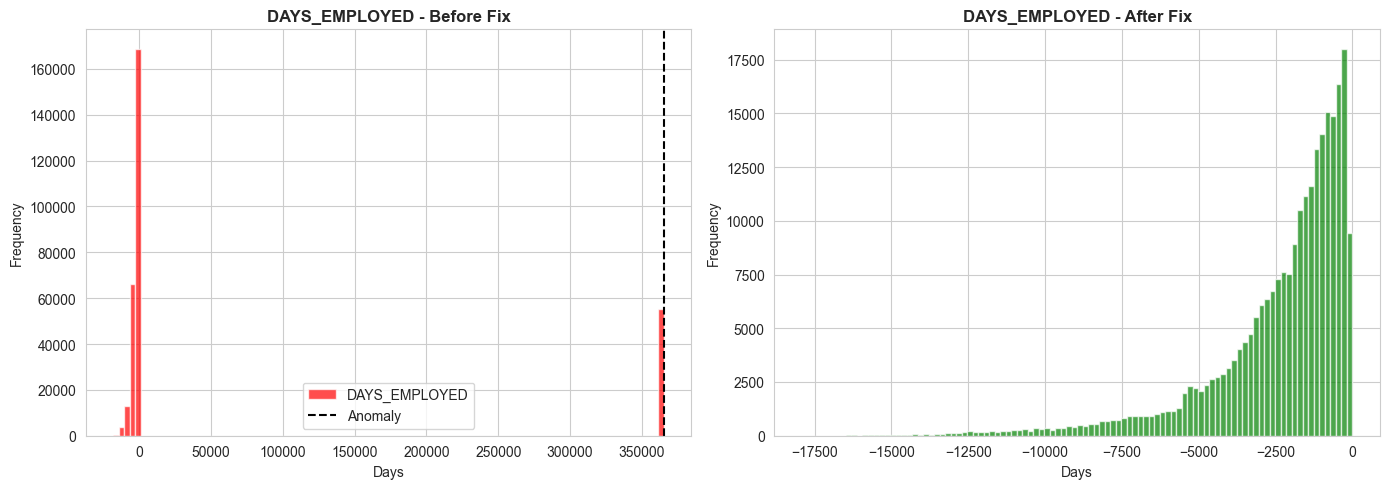

In [4]:
# Visualize before/after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
df_train['DAYS_EMPLOYED'].plot(kind='hist', bins=100, ax=axes[0], color='red', alpha=0.7)
axes[0].set_title('DAYS_EMPLOYED - Before Fix', fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].axvline(365243, color='black', linestyle='--', label='Anomaly')
axes[0].legend()

# After
df_train_clean = df_train.copy()
df_train_clean['DAYS_EMPLOYED'] = df_train_clean['DAYS_EMPLOYED'].replace(365243, np.nan)
df_train_clean['DAYS_EMPLOYED'].plot(kind='hist', bins=100, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('DAYS_EMPLOYED - After Fix', fontweight='bold')
axes[1].set_xlabel('Days')

plt.tight_layout()
plt.show()

✅ Fix: Replace 365243 with NaN

### 2.2 Other Domain Anomalies

In [5]:
# Check negative days (should be negative, representing days before application)
days_columns = [col for col in df_train.columns if 'DAYS' in col]

print("Days columns analysis:")
for col in days_columns:
    print(f"\n{col}:")
    print(f"  Min: {df_train[col].min():.0f}")
    print(f"  Max: {df_train[col].max():.0f}")
    print(f"  Positive values: {(df_train[col] > 0).sum()}")

Days columns analysis:

DAYS_BIRTH:
  Min: -25229
  Max: -7489
  Positive values: 0

DAYS_EMPLOYED:
  Min: -17912
  Max: 365243
  Positive values: 55374

DAYS_REGISTRATION:
  Min: -24672
  Max: 0
  Positive values: 0

DAYS_ID_PUBLISH:
  Min: -7197
  Max: 0
  Positive values: 0

DAYS_LAST_PHONE_CHANGE:
  Min: -4292
  Max: 0
  Positive values: 0


### 💡 COMMENTS: 
- DAYS columns should be negative (days before application)
- Positive values in DAYS_EMPLOYED are the 365243 anomaly

## 3. Statistical Outlier Detection (IQR Method)

In [6]:
def detect_outliers_iqr(df, column, multiplier=1.5):
    """
    Detect outliers using IQR method
    multiplier: 1.5 for standard, 3.0 for extreme outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

In [7]:
# Analyze key financial features
financial_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

outlier_summary = []

for col in financial_features:
    outliers, lower, upper = detect_outliers_iqr(df_train_clean, col)
    outlier_pct = len(outliers) / len(df_train_clean) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': len(outliers),
        'Percentage': outlier_pct,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Summary:")
print(outlier_df)

Outlier Summary:
            Feature  Outliers  Percentage  Lower_Bound  Upper_Bound
0  AMT_INCOME_TOTAL     14035    4.564064     -22500.0     337500.0
1        AMT_CREDIT      6562    2.133907    -537975.0    1616625.0
2       AMT_ANNUITY      7504    2.440238     -10584.0      61704.0
3   AMT_GOODS_PRICE     14728    4.789422    -423000.0    1341000.0


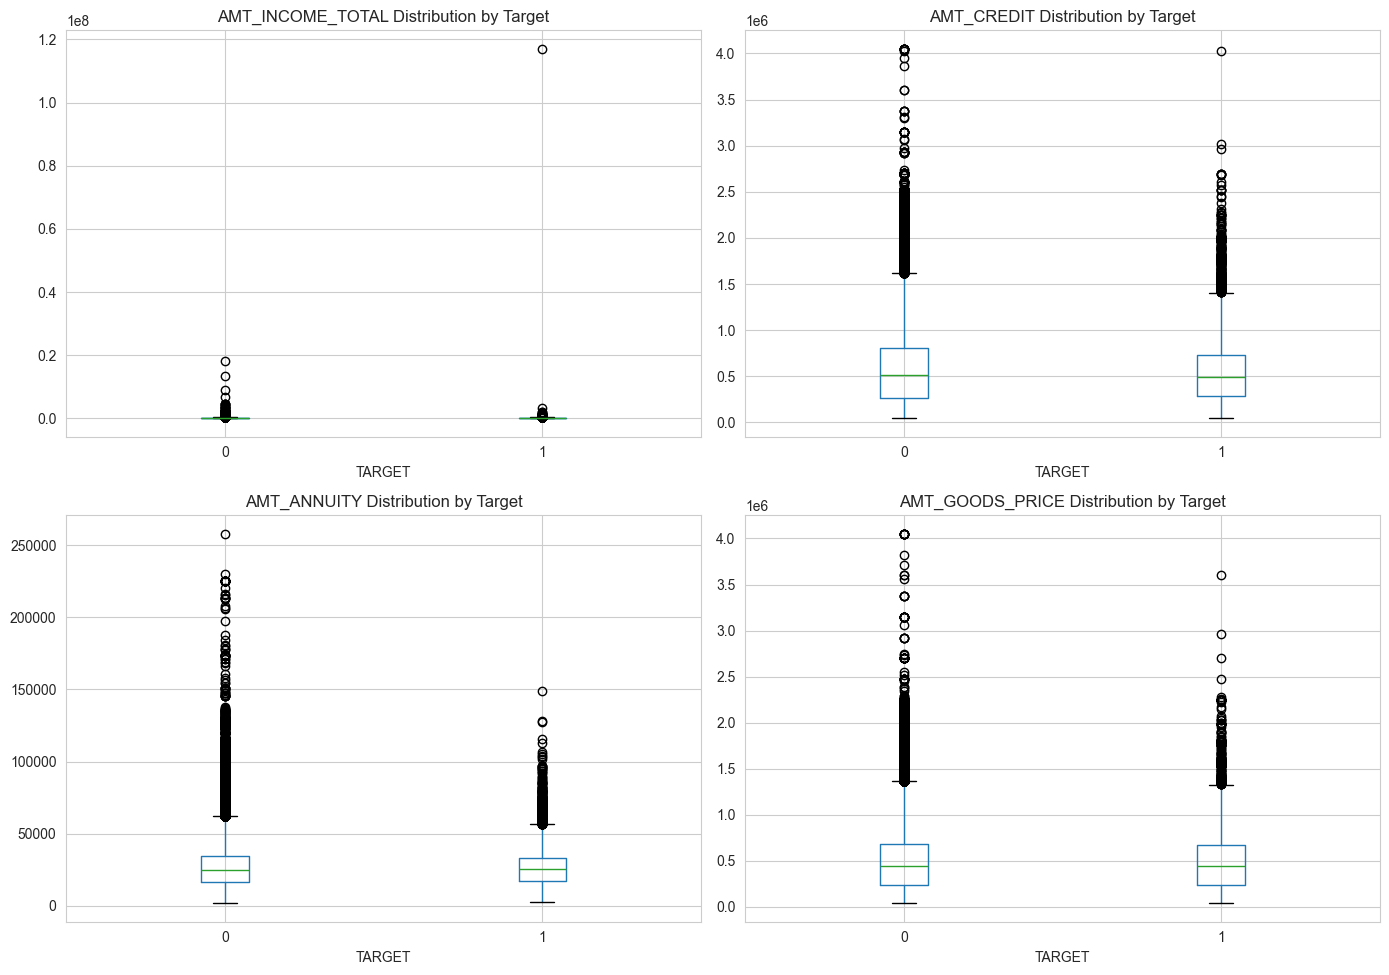

In [8]:
# Visualize outliers with box plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(financial_features):
    df_train_clean.boxplot(column=col, by='TARGET', ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution by Target')
    axes[idx].set_xlabel('TARGET')

plt.suptitle('') # Remove automatic title
plt.tight_layout()
plt.show()

## 4. Age Analysis

Age Statistics:
count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE_YEARS, dtype: float64

Applicants under 20: 0
Applicants over 70: 0


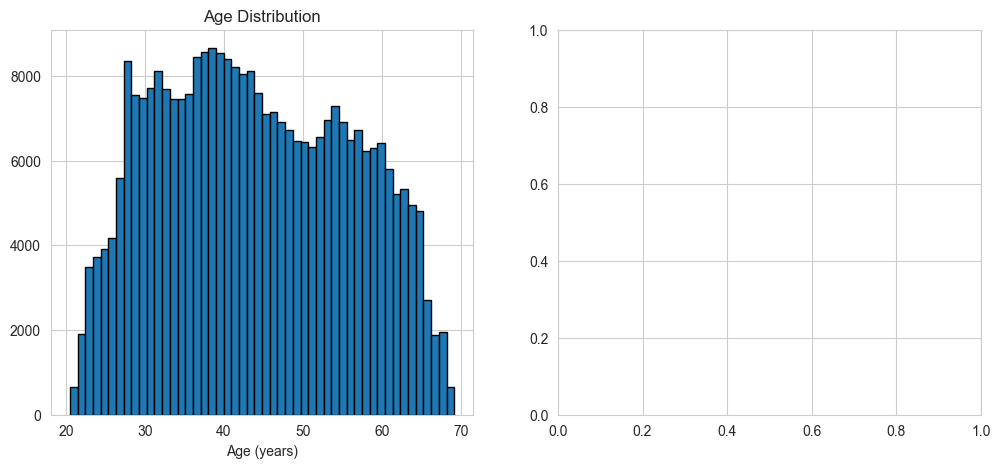

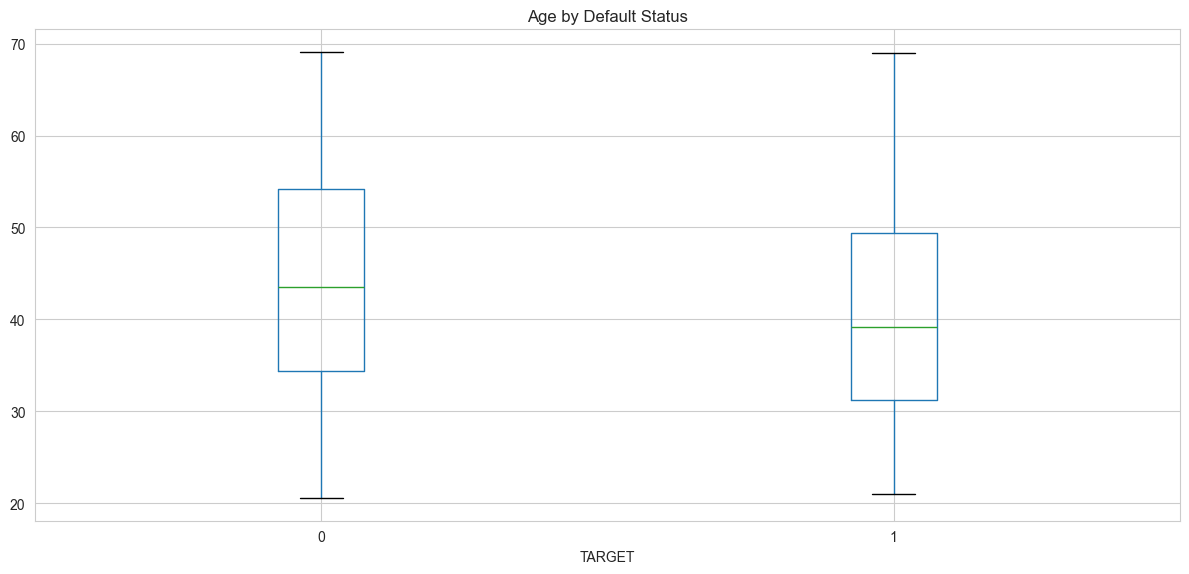

In [9]:
# Convert DAYS_BIRTH to years
df_train_clean['AGE_YEARS'] = -df_train_clean['DAYS_BIRTH'] / 365

print("Age Statistics:")
print(df_train_clean['AGE_YEARS'].describe())

# Check unrealistic ages
print(f"\nApplicants under 20: {(df_train_clean['AGE_YEARS'] < 20).sum()}")
print(f"Applicants over 70: {(df_train_clean['AGE_YEARS'] > 70).sum()}")

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_train_clean['AGE_YEARS'].hist(bins=50, edgecolor='black')
plt.xlabel('Age (years)')
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
df_train_clean.boxplot(column='AGE_YEARS', by='TARGET')
plt.xlabel('TARGET')
plt.title('Age by Default Status')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 5. Multivariate Outlier Detection (Isolation Forest)

In [10]:
# Select key features for multivariate analysis
features_for_iso = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                    'AGE_YEARS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Prepare data (fill NaN for Isolation Forest)
X = df_train_clean[features_for_iso].fillna(df_train_clean[features_for_iso].median())

print(f"Running Isolation Forest on {X.shape[0]} samples with {X.shape[1]} features...")

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% outliers
    random_state=42,
    n_jobs=-1
)

outlier_labels = iso_forest.fit_predict(X)
outlier_scores = iso_forest.score_samples(X)

# Add to dataframe
df_train_clean['outlier_label'] = outlier_labels  # -1 for outliers, 1 for inliers
df_train_clean['outlier_score'] = outlier_scores

n_outliers = (outlier_labels == -1).sum()
print(f"\nOutliers detected: {n_outliers} ({n_outliers/len(df_train_clean)*100:.2f}%)")

Running Isolation Forest on 307511 samples with 7 features...

Outliers detected: 15376 (5.00%)


Outlier Analysis:

Default rate by outlier status:
                   mean   count
outlier_label                  
-1             0.095864   15376
 1             0.079932  292135


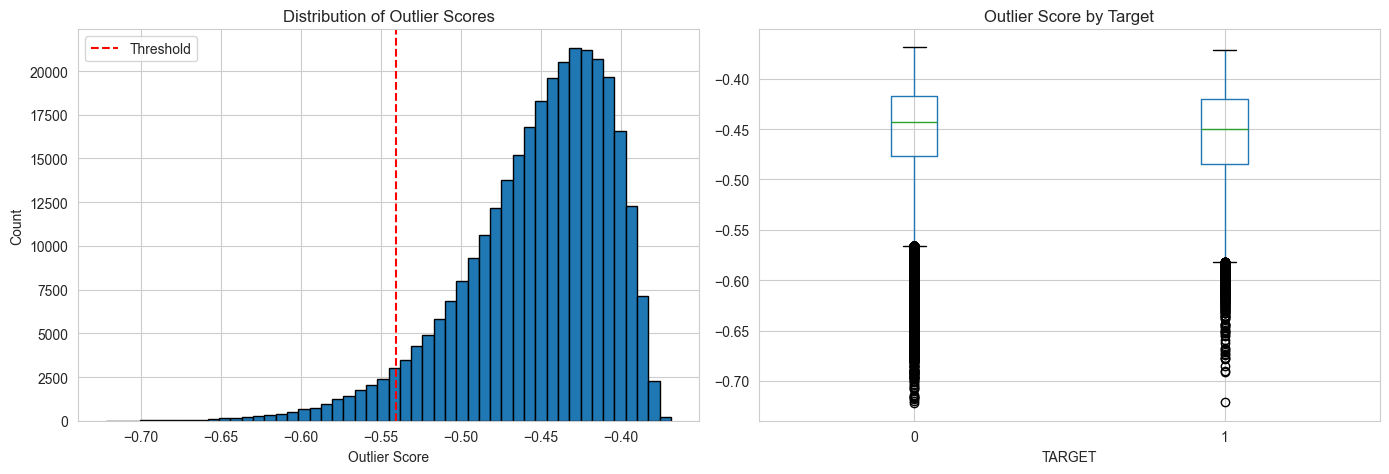

In [11]:
# Analyze outliers
print("Outlier Analysis:")
print("\nDefault rate by outlier status:")
print(df_train_clean.groupby('outlier_label')['TARGET'].agg(['mean', 'count']))

# Visualize outlier scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score distribution
axes[0].hist(outlier_scores, bins=50, edgecolor='black')
axes[0].set_xlabel('Outlier Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Outlier Scores')
axes[0].axvline(iso_forest.offset_, color='red', linestyle='--', label='Threshold')
axes[0].legend()

# Score by target
df_train_clean.boxplot(column='outlier_score', by='TARGET', ax=axes[1])
axes[1].set_title('Outlier Score by Target')
axes[1].set_xlabel('TARGET')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 6. Cap Extreme Values

In [12]:
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    """
    Cap extreme values at specified percentiles
    """
    lower_cap = df[column].quantile(lower_percentile)
    upper_cap = df[column].quantile(upper_percentile)
    
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    
    return df, lower_cap, upper_cap

# Apply capping to financial features
df_capped = df_train_clean.copy()

for col in financial_features:
    df_capped, lower, upper = cap_outliers(df_capped, col)
    print(f"{col}: capped at [{lower:.0f}, {upper:.0f}]")

AMT_INCOME_TOTAL: capped at [45000, 472500]
AMT_CREDIT: capped at [76410, 1854000]
AMT_ANNUITY: capped at [6183, 70006]
AMT_GOODS_PRICE: capped at [67500, 1800000]


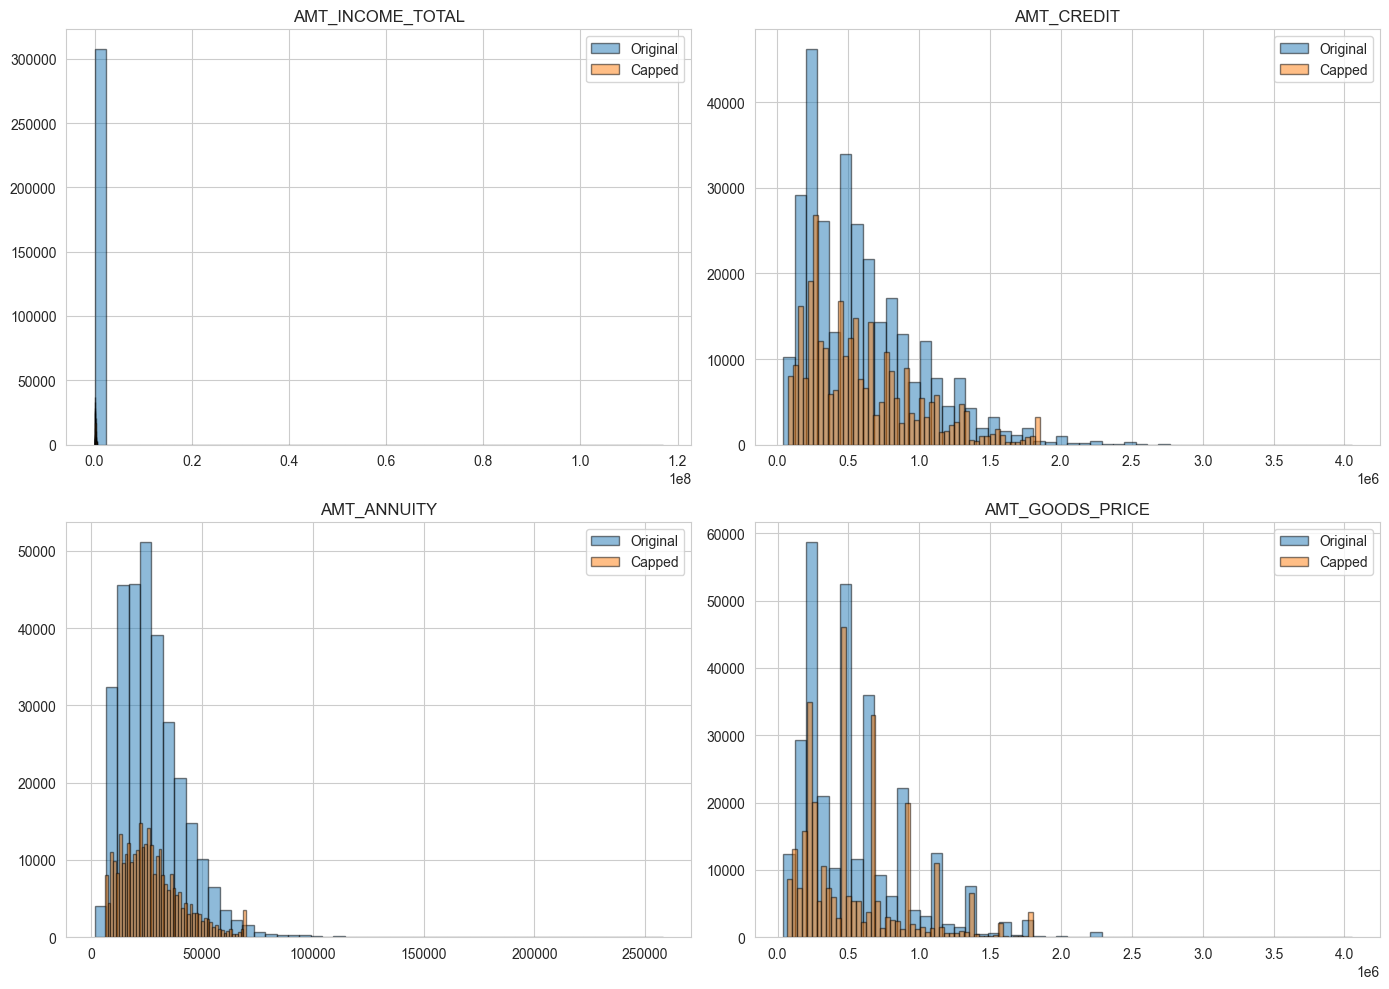

In [13]:
# Compare before/after capping
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, col in enumerate(financial_features):
    # Before
    axes[idx].hist(df_train_clean[col], bins=50, alpha=0.5, label='Original', edgecolor='black')
    # After
    axes[idx].hist(df_capped[col], bins=50, alpha=0.5, label='Capped', edgecolor='black')
    axes[idx].set_title(f'{col}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 7. Summary and Save Cleaned Data

In [14]:
# Create final cleaned dataset
df_final = df_capped.copy()

print("=" * 60)
print("CLEANING SUMMARY")
print("=" * 60)
print(f"Original shape: {df_train.shape}")
print(f"After cleaning: {df_final.shape}")
print(f"\nChanges applied:")
print("  ✅ DAYS_EMPLOYED: 365243 → NaN")
print("  ✅ AGE_YEARS: Created from DAYS_BIRTH")
print("  ✅ Financial features: Capped at 1st and 99th percentiles")
print("  ✅ Outlier detection: Isolation Forest labels added")
print(f"\nDefault rate: {df_final['TARGET'].mean():.4%} (unchanged)")
print("=" * 60)

CLEANING SUMMARY
Original shape: (307511, 122)
After cleaning: (307511, 125)

Changes applied:
  ✅ DAYS_EMPLOYED: 365243 → NaN
  ✅ AGE_YEARS: Created from DAYS_BIRTH
  ✅ Financial features: Capped at 1st and 99th percentiles
  ✅ Outlier detection: Isolation Forest labels added

Default rate: 8.0729% (unchanged)


In [15]:
# Save cleaned data
output_dir = Path('../../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'application_train_cleaned.csv'
df_final.to_csv(output_file, index=False)

print(f"✅ Cleaned data saved to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024**2:.2f} MB")

✅ Cleaned data saved to: ..\..\data\processed\application_train_cleaned.csv
File size: 169.82 MB


## Next Steps

✅ **Completed:**
- Domain-specific anomaly handling (DAYS_EMPLOYED anomaly fixed)
- Statistical outlier detection (IQR method on financial features)
- Multivariate outlier detection (Isolation Forest)
- Extreme value capping (1st-99th percentiles)
- Cleaned data saved to `application_train_cleaned.csv`

⏭️ **Next:** Feature Engineering (notebook 03)

Notebook 03 will implement comprehensive feature engineering with **19 sections**:
- **Basic Features** (1-8): Domain knowledge features, age groups, income ratios, credit ratios, external source combinations, document flags, region features, time features
- **Advanced Features** (9-12): KNN target encoding (k=500), time-sliced aggregations, past due analysis, advanced bureau features
- **External Aggregations** (13-17): Bureau, previous applications, POS_CASH, credit card, installments aggregations
- **Data Quality** (18-19): Missing value handling, correlation analysis, feature selection

Expected output: ~280-300 engineered features for model training